In [37]:
import pandas as np
df = np.read_csv('mbti_1.csv')

# populating types array
labels = []
for _type in df['type']:
     labels.append(_type)

In [38]:
import pickle

posts = []
with open ('processed_posts.pkl', 'rb') as fp:
    posts = pickle.load(fp)

In [39]:
tokenized_posts = []

for post in posts:
    user = []
    for sentence in post:
        user += sentence.split(" ")
        
    tokenized_posts.append(user)

In [40]:
all_words_list = []

for user in tokenized_posts:
    for word in user:
        all_words_list.append(word)

In [41]:
from collections import Counter

In [42]:
freq_list = Counter(all_words_list)
dictionary = freq_list.most_common(10000)

In [43]:
dictionary = list(zip(*dictionary))[0]

In [44]:
nums = range(0, 10000)
word_int = dict(zip(dictionary, nums))

In [45]:
x_vals = []
for user in tokenized_posts:
    x_vals.append([word_int[x] for x in user if x in word_int.keys()])

In [46]:
def to_one_hot(arr):
    
    one_hot_array = []
    type_dictionary = {
            "T": 0,
            "F": 1
        }
    
    for label in arr:
        one_hot_array.append(type_dictionary[label[2]])
        
    return one_hot_array

In [47]:
import numpy as np
from keras.utils.np_utils import to_categorical

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

x = vectorize_sequences(x_vals)
y = np.asarray(to_one_hot(labels)).astype('float32')

In [48]:
indices = np.arange(x.shape[0])
np.random.shuffle(indices)
x = x[indices]
y = y[indices]

In [49]:
x_test = x[:1000]
y_test = y[:1000]

x_train = x[1000:]
y_train = y[1000:]

x_val = x_train[:500]
y_val = y_train[:500]

partial_x_train = x_train[500:]
partial_y_train = y_train[500:]

In [50]:
#These are for full label prediction
#class_weights = [{0:1, 1:8}, {0:1, 1:6.24}, {0:1, 1:1.18}, {0:1, 1:0.65}]
class_weights = {0:1, 1:1.18}

In [52]:
# FEED FORWARD MODEL
from keras import models
from keras import layers
from keras.regularizers import l2
import tensorflow as tf
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(32, activation='relu', input_shape = (10000,)))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer = 'rmsprop',
                  loss = 'binary_crossentropy',
                  metrics = ['acc'])
    return model

In [57]:
from keras.callbacks import Callback

class True_eval(Callback):
    def __init__(self, validation_data):
        self.validation_data = validation_data
        self.total_accuracy = []
        self.i_accuracy = []
        self.e_accuracy = []
    
    def ie_real_acc(self, prediction):
        y_true = self.validation_data[1]
        i_acc = 0
        i_total = 0
        e_acc = 0
        e_total = 0
        for i in range(0, len(prediction)):
            if (y_true[i].round() == 0):
                if (prediction[i].round() == y_true[i]):
                    i_acc += 1
                i_total += 1
            else:
                if (prediction[i].round() == y_true[i]):
                    e_acc += 1
                e_total += 1
        return (i_acc/i_total), (e_acc/e_total)
    

    def on_epoch_end(self, epoch, logs={}):
        x_val = self.validation_data[0]
        y_pred = self.model.predict(x_val)
        i_real_acc, e_real_acc = self.ie_real_acc(y_pred)
        print ("T Acc: %f" % i_real_acc)
        print ("F Acc: %f" % e_real_acc)
        self.i_accuracy.append(i_real_acc)
        self.e_accuracy.append(e_real_acc)

In [68]:
model = build_model()
with tf.device('/gpu:0'):
    true_metrics = True_eval((x_val, y_val))
    history = model.fit(partial_x_train, partial_y_train,
                        validation_data= (x_val, y_val),
                        epochs = 300, batch_size = 512,
                        class_weight=class_weights,
                        callbacks=[true_metrics])

Train on 7175 samples, validate on 500 samples
Epoch 1/300
7175/7175 [==============================] - 1s 200us/step - loss: 0.7194 - acc: 0.6028 - val_loss: 0.5802 - val_acc: 0.7480
T Acc: 0.877828
F Acc: 0.645161
Epoch 2/300
7175/7175 [==============================] - 1s 131us/step - loss: 0.5996 - acc: 0.7201 - val_loss: 0.5407 - val_acc: 0.6920
T Acc: 0.348416
F Acc: 0.964158
Epoch 3/300
7175/7175 [==============================] - 1s 110us/step - loss: 0.5164 - acc: 0.7816 - val_loss: 0.4807 - val_acc: 0.7620
T Acc: 0.556561
F Acc: 0.924731
Epoch 4/300
7175/7175 [==============================] - 1s 141us/step - loss: 0.4547 - acc: 0.8183 - val_loss: 0.5644 - val_acc: 0.7120
T Acc: 0.972851
F Acc: 0.505376
Epoch 5/300
7175/7175 [==============================] - 1s 113us/step - loss: 0.4161 - acc: 0.8374 - val_loss: 0.4437 - val_acc: 0.7940
T Acc: 0.846154
F Acc: 0.752688
Epoch 6/300
7175/7175 [==============================] - 1s 105us/step - loss: 0.3708 - acc: 0.8602 - val_lo

7175/7175 [==============================] - 1s 97us/step - loss: 5.6460e-04 - acc: 1.0000 - val_loss: 1.0429 - val_acc: 0.7880
T Acc: 0.742081
F Acc: 0.824373
Epoch 50/300
7175/7175 [==============================] - 1s 95us/step - loss: 4.4858e-04 - acc: 1.0000 - val_loss: 1.1812 - val_acc: 0.7820
T Acc: 0.669683
F Acc: 0.870968
Epoch 51/300
7175/7175 [==============================] - 1s 93us/step - loss: 0.3896 - acc: 0.9660 - val_loss: 1.0481 - val_acc: 0.7920
T Acc: 0.683258
F Acc: 0.878136
Epoch 52/300
7175/7175 [==============================] - 1s 95us/step - loss: 7.9338e-04 - acc: 1.0000 - val_loss: 1.0090 - val_acc: 0.7800
T Acc: 0.696833
F Acc: 0.845878
Epoch 53/300
7175/7175 [==============================] - 1s 99us/step - loss: 6.0839e-04 - acc: 1.0000 - val_loss: 0.9965 - val_acc: 0.7840
T Acc: 0.719457
F Acc: 0.835125
Epoch 54/300
7175/7175 [==============================] - 1s 96us/step - loss: 5.1889e-04 - acc: 1.0000 - val_loss: 1.0398 - val_acc: 0.7780
T Acc: 0.70

7175/7175 [==============================] - 1s 93us/step - loss: 4.7378e-05 - acc: 1.0000 - val_loss: 1.6524 - val_acc: 0.7880
T Acc: 0.728507
F Acc: 0.835125
Epoch 97/300
7175/7175 [==============================] - 1s 93us/step - loss: 4.2103e-05 - acc: 1.0000 - val_loss: 1.7173 - val_acc: 0.7780
T Acc: 0.696833
F Acc: 0.842294
Epoch 98/300
7175/7175 [==============================] - 1s 93us/step - loss: 3.7471e-05 - acc: 1.0000 - val_loss: 1.7340 - val_acc: 0.7820
T Acc: 0.728507
F Acc: 0.824373
Epoch 99/300
7175/7175 [==============================] - 1s 95us/step - loss: 3.2533e-05 - acc: 1.0000 - val_loss: 1.7722 - val_acc: 0.7820
T Acc: 0.733032
F Acc: 0.820789
Epoch 100/300
7175/7175 [==============================] - 1s 93us/step - loss: 2.8123e-05 - acc: 1.0000 - val_loss: 1.8163 - val_acc: 0.7780
T Acc: 0.696833
F Acc: 0.842294
Epoch 101/300
7175/7175 [==============================] - 1s 94us/step - loss: 2.4299e-05 - acc: 1.0000 - val_loss: 1.8264 - val_acc: 0.7800
T Acc

7175/7175 [==============================] - 1s 95us/step - loss: 1.3771e-07 - acc: 1.0000 - val_loss: 2.3190 - val_acc: 0.7860
T Acc: 0.733032
F Acc: 0.827957
Epoch 144/300
7175/7175 [==============================] - 1s 93us/step - loss: 1.3623e-07 - acc: 1.0000 - val_loss: 2.3216 - val_acc: 0.7860
T Acc: 0.733032
F Acc: 0.827957
Epoch 145/300
7175/7175 [==============================] - 1s 92us/step - loss: 1.3498e-07 - acc: 1.0000 - val_loss: 2.3239 - val_acc: 0.7860
T Acc: 0.733032
F Acc: 0.827957
Epoch 146/300
7175/7175 [==============================] - 1s 93us/step - loss: 1.3385e-07 - acc: 1.0000 - val_loss: 2.3264 - val_acc: 0.7860
T Acc: 0.733032
F Acc: 0.827957
Epoch 147/300
7175/7175 [==============================] - 1s 99us/step - loss: 1.3292e-07 - acc: 1.0000 - val_loss: 2.3286 - val_acc: 0.7860
T Acc: 0.733032
F Acc: 0.827957
Epoch 148/300
7175/7175 [==============================] - 1s 95us/step - loss: 1.3209e-07 - acc: 1.0000 - val_loss: 2.3307 - val_acc: 0.7860
T 

7175/7175 [==============================] - 1s 94us/step - loss: 1.2395e-07 - acc: 1.0000 - val_loss: 2.3972 - val_acc: 0.7840
T Acc: 0.746606
F Acc: 0.813620
Epoch 191/300
7175/7175 [==============================] - 1s 93us/step - loss: 1.2390e-07 - acc: 1.0000 - val_loss: 2.3981 - val_acc: 0.7840
T Acc: 0.746606
F Acc: 0.813620
Epoch 192/300
7175/7175 [==============================] - 1s 91us/step - loss: 1.2385e-07 - acc: 1.0000 - val_loss: 2.3989 - val_acc: 0.7840
T Acc: 0.746606
F Acc: 0.813620
Epoch 193/300
7175/7175 [==============================] - 1s 93us/step - loss: 1.2382e-07 - acc: 1.0000 - val_loss: 2.3997 - val_acc: 0.7840
T Acc: 0.746606
F Acc: 0.813620
Epoch 194/300
7175/7175 [==============================] - 1s 108us/step - loss: 1.2377e-07 - acc: 1.0000 - val_loss: 2.4007 - val_acc: 0.7840
T Acc: 0.746606
F Acc: 0.813620
Epoch 195/300
7175/7175 [==============================] - 1s 98us/step - loss: 1.2373e-07 - acc: 1.0000 - val_loss: 2.4015 - val_acc: 0.7840
T

7175/7175 [==============================] - 1s 96us/step - loss: 1.2287e-07 - acc: 1.0000 - val_loss: 2.4277 - val_acc: 0.7800
T Acc: 0.746606
F Acc: 0.806452
Epoch 238/300
7175/7175 [==============================] - 1s 107us/step - loss: 1.2287e-07 - acc: 1.0000 - val_loss: 2.4280 - val_acc: 0.7800
T Acc: 0.746606
F Acc: 0.806452
Epoch 239/300
7175/7175 [==============================] - 1s 102us/step - loss: 1.2287e-07 - acc: 1.0000 - val_loss: 2.4286 - val_acc: 0.7800
T Acc: 0.746606
F Acc: 0.806452
Epoch 240/300
7175/7175 [==============================] - 1s 120us/step - loss: 1.2285e-07 - acc: 1.0000 - val_loss: 2.4290 - val_acc: 0.7800
T Acc: 0.746606
F Acc: 0.806452
Epoch 241/300
7175/7175 [==============================] - 1s 151us/step - loss: 1.2283e-07 - acc: 1.0000 - val_loss: 2.4274 - val_acc: 0.7800
T Acc: 0.746606
F Acc: 0.806452
Epoch 242/300
7175/7175 [==============================] - 1s 103us/step - loss: 1.2282e-07 - acc: 1.0000 - val_loss: 2.4279 - val_acc: 0.78

7175/7175 [==============================] - 1s 86us/step - loss: 1.2248e-07 - acc: 1.0000 - val_loss: 2.4422 - val_acc: 0.7800
T Acc: 0.746606
F Acc: 0.806452
Epoch 285/300
7175/7175 [==============================] - 1s 90us/step - loss: 1.2248e-07 - acc: 1.0000 - val_loss: 2.4426 - val_acc: 0.7800
T Acc: 0.746606
F Acc: 0.806452
Epoch 286/300
7175/7175 [==============================] - 1s 88us/step - loss: 1.2248e-07 - acc: 1.0000 - val_loss: 2.4430 - val_acc: 0.7800
T Acc: 0.746606
F Acc: 0.806452
Epoch 287/300
7175/7175 [==============================] - 1s 86us/step - loss: 1.2247e-07 - acc: 1.0000 - val_loss: 2.4434 - val_acc: 0.7800
T Acc: 0.746606
F Acc: 0.806452
Epoch 288/300
7175/7175 [==============================] - 1s 98us/step - loss: 1.2247e-07 - acc: 1.0000 - val_loss: 2.4429 - val_acc: 0.7800
T Acc: 0.746606
F Acc: 0.806452
Epoch 289/300
7175/7175 [==============================] - 1s 100us/step - loss: 1.2247e-07 - acc: 1.0000 - val_loss: 2.4428 - val_acc: 0.7800
T

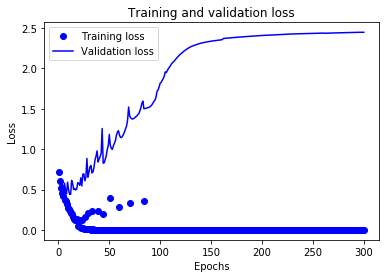

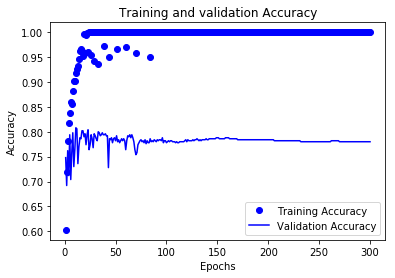

<Figure size 432x288 with 0 Axes>

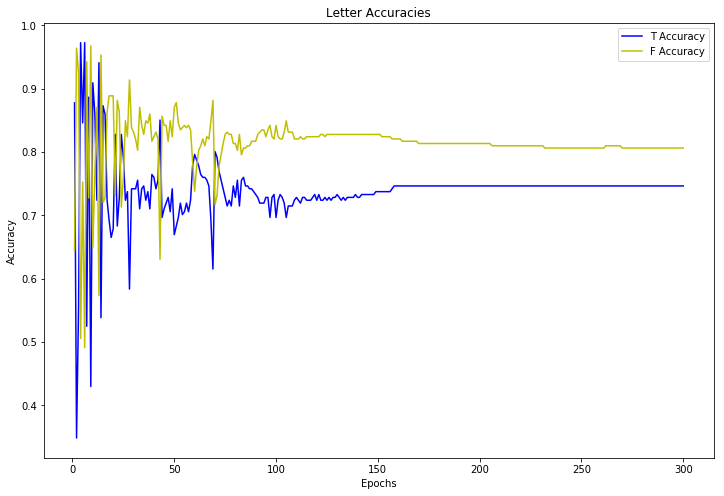

In [69]:
import matplotlib.pyplot as plt

history_dict = history.history
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']

train_acc = history_dict['acc']
val_acc   = history_dict['val_acc']

epochs = range(1, len(history_dict['acc']) + 1)

plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()

plt.plot(epochs, train_acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

plt.clf()

plt.figure(figsize=(12,8))
plt.plot(epochs, true_metrics.i_accuracy, 'b', label='T Accuracy')
plt.plot(epochs, true_metrics.e_accuracy, 'y', label='F Accuracy')
plt.title('Letter Accuracies')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [67]:
model = build_model()
with tf.device('/gpu:0'):
    model.fit(x_train, y_train, epochs = 7, batch_size = 512, class_weight=class_weights)
    y_pred = model.predict(x_test)
    results = model.evaluate(x_test, y_test)
results

Epoch 1/7
7675/7675 [==============================] - 1s 170us/step - loss: 0.7350 - acc: 0.5676
Epoch 2/7
7675/7675 [==============================] - 1s 94us/step - loss: 0.6249 - acc: 0.6860
Epoch 3/7
7675/7675 [==============================] - 1s 88us/step - loss: 0.5262 - acc: 0.7668
Epoch 4/7
7675/7675 [==============================] - 1s 92us/step - loss: 0.4569 - acc: 0.8096
Epoch 5/7
7675/7675 [==============================] - 1s 89us/step - loss: 0.4080 - acc: 0.8416
Epoch 6/7
7675/7675 [==============================] - 1s 96us/step - loss: 0.3891 - acc: 0.8438
Epoch 7/7
1000/1000 [==============================] - 0s 224us/step


[0.514714617729187, 0.737]